In [3]:
import cvxpy as cp # (Convex) Optimization library
import numpy as np  # Numerical operations
import pandas as pd # Data manipilation and analysis

import matplotlib.pyplot as plt # Visualization library

### Q1: Supply Chain Optimization under Demand Uncertainty
Consider Supply Chain Optimization under Demand Uncertainty. Demand for electronic supply in Nairobi in the past two weeks together with their respective probability is given 
below
| **Number** | 255 | 302 | 270 | 317 | 285 | 332 | 300 | 347 | 315 | 362 | 330 | 262 | 309 | 277 |
|--------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| **Prob**   | 0.03| 0.15| 0.04| 0.1 | 0.05| 0.05| 0.09| 0.01| 0.09| 0.03| 0.2 | 0.07| 0.05| 0.04|


Consider constraints = [supply >= 120, supply <= 330]. 

Compute the optimal supply.


In [4]:
## Demand values and their probabilities
demand= np.array([255, 302, 270, 317, 285, 332, 300, 347, 315, 362, 330, 262, 309, 277])
prob= np.array([0.03, 0.15, 0.04, 0.1, 0.05, 0.05, 0.09, 0.01, 0.09, 0.03, 0.2, 0.07, 0.05, 0.04])

## Sum of probabilities should be 1
print(f'Sum of probabilties {prob.sum():.2f}')

Sum of probabilties 1.00


#### Solution
Based on the past demand values and their probabilities, our goal is to determine the optimal amount of supply that would minimize costs. The two supply scenarios relative to demand are:
- **Excess Supply**- The amount of supply is greater than the amount of demand (supply - demand)
- **Shortage of Supply**- The amount of supply is less than the amount of demand (demand - supply)


Where (supply - demand), (demand - supply) are the excess and deficit units of inventory respectively.


There are costs associated with each scenario: 
- **Overage Cost (Co)**- Cost of ordering too much, over-supplying (eg- Wastage, high storage costs, etc) 
- **Underage Cost (Cu)**- Cost of ordering to little, under-supplying (eg- Shortage penalty, missed sales opportunities)
     

For simplicity we shall assume both costs are equal (Co = Cu = 1) therefore, in each scenario total cost is calculated as: 
- ****Excess Cost**** $C_o * (supply - demand)$ when supply is excess
- **Shortage Cost** $Cu * (demand - supply)$ when supply is low


Since demand is uncertain, we shall compute the total cost under each demand scenario, then multiplying by its respective probability. A weighted sum of each product gives us the total *expected cost*. This is the objective function we aim to minimize. 
$$\sum P_i \cdot (Excess \, or \, Shortage \, Cost)$$


Writing the objective function in full gives us:
$$Min \space \space \sum P_i \cdot (C_o \cdot max(s_i - d_i, 0) + C_u \cdot max(d_i - s_i, 0))$$
Where $max(s_i - d_i, 0)$ is the excess supply and $max(d_i - s_i, 0)$ is the shortage of supply.
     

##### CvxPy Implementation

In [5]:
## Our decision variable (what we want to optimize) is supply
supply= cp.Variable()

## Cost Parameters (assuming excess cost equal to shortage cost)
Co= 1 # Overage Cost
Cu= 1 # Underage Cost

## Expected cost
expected_cost= cp.sum(prob @ (Co * cp.pos(supply - demand) + 
                              Cu * cp.pos(demand - supply)))
 # cp.pos computes the positive part of x such that cp.pos(x)= max(x, 0)
 
## Constraints (120 <= supply <= 330)
cons_supply= [supply >= 120, supply <= 330]

## Objective function, Minimization
opt_supply= cp.Problem(cp.Minimize(expected_cost), cons_supply)
opt_supply.solve()

## Results
print(f'Optimal Supply: {supply.value:.2f}')
print(f'Lowest Expected Cost: {opt_supply.value:.2f}', )


Optimal Supply: 309.00
Lowest Expected Cost: 19.47


The optimal supply is determined by minimzing the expected cost across all possible demand scenarios. we see that by supplying 309 units, we can acheive a minimal cost of 19.47 per unit. Any higher or lower supply will result in a higher cost per unit.

##### Manual Implementation

In [ ]:
## Supply Constraints
min_supply= 120
max_supply= 330

## Cost Parameters
Co= 1
cu= 1

## A function to compute expected cost
def expected_cost(supply, demand, probability, overage_cost= Co, underage_cost= Cu):
    # During excess supply
    overage= np.maximum(supply - demand, 0)
    # During shortage of supply
    underage= np.maximum(demand - supply, 0)
    # Total Cost
    total_cost= overage_cost*overage + underage_cost*underage
    # Expected cost
    return np.sum(probability * total_cost)

## We shall compute the expected cost using the below supply values within the specified constraints
supply_values= np.sort(demand[(demand>= 120) & (demand<= 330)]) 
 # Sorted the cost values in acescending order. This will especially be usefule during plotting

supply_costs= []
for s in supply_values:
    cost= expected_cost(s, demand, prob)
    supply_costs.append(cost)
 # Supply values are multiplied by the demand arrays and corresponding probabilities element-wise

## Finding the minimum expected cost
min_cost_id= np.argmin(supply_costs) # np.argmin() returns the index of the minimum value
min_cost= supply_costs[min_cost_id]
optimal_supply= supply_values[min_cost_id]

## Results
print(f'Optimal Supply: {optimal_supply}')
print(f'Optimal Cost: {min_cost}')

Optimal Supply: 309
Optimal Cost: 19.47


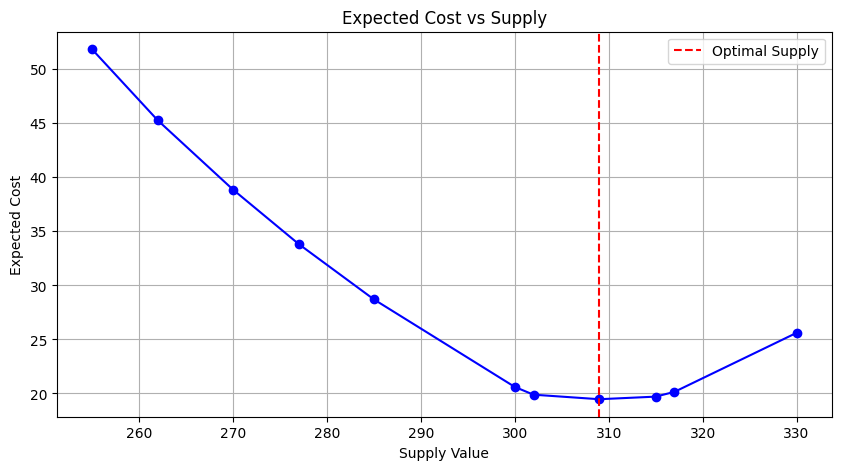

In [7]:
## Plotting the Expected costs against the various corresponding supply values
plt.figure(figsize= (10, 5))
plt.plot(supply_values, supply_costs, color= 'blue', marker= 'o')
plt.axvline(x= optimal_supply, color= 'red', linestyle= '--', label= 'Optimal Supply')

plt.xlabel('Supply Value')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs Supply')
plt.legend()
plt.grid()


The graph confirms our minimum cost at 19.47 and optimal supply at 309 units.

### Q2: Healthcare Resource Allocation with Uncertain Demand
Consider ICU Bed Allocation under Uncertain Patient Arrivals. Number of unscheduled arrivals at Kenyatta National Hospital in the last 10 days and their assigned probabilites are as follows:

| Patients | 25 | 20 | 30 | 50 | 27 | 39 | 42 | 29 | 35 | 42 |
|----------|----|----|----|----|----|----|----|----|----|----|
| Prob     | 0.1| 0.1| 0.08| 0.15| 0.09| 0.05| 0.1| 0.1| 0.13| 0.1|

Consider bed constraints = [beds >= 17, beds <= 55]. Compute the 
Optimal number of ICU beds allocation

In [8]:
## No of beds and their probabilties
patients= np.array([25, 20, 30, 50, 27, 39, 42, 29, 35, 42])
prob_beds= np.array([0.1, 0.1, 0.08, 0.15, 0.09, 0.05, 0.1, 0.1, 0.13, 0.1])

## Sum of probabilities should be 1
print(f'Sum of probabilties {prob_beds.sum():.2f}')

Sum of probabilties 1.00


#### Solution
Just as was done in Q1, our goal here is similar. To minimize the cost of allocating beds to patients. We have the following possible scenarios:
- **Excess Beds**: More beds are allocated than needed (beds-patients)
- **Shortage of Beds**: Fewer beds than number of available patients (patients-beds)

Each scenario has a cost associated with it:
- Cost of Excess Beds (Bx)
- Cost of Shortage of Beds (Bs)

In a healthcare setting, the cost of insufficient beds should be higher than the cost of excess beds, as it would mean fewer patients would be admitted therefore less revenue. Therefore, we set:
- $B_s = 3$
- $B_x = 1$

As the demand for beds is uncertain, we shall compute the total expcted cost of allocating beds to patients as:
$$Min \space \space \sum P_i \cdot (B_x \cdot Max(Beds_i- Patients_i) + B_s \cdot Max(Patients_i - Beds_i, 0))$$

##### CvxPy Implementation

In [10]:
## Decision Variable
beds= cp.Variable()

## Cost Parameters
Bs= 3
Bx= 1

## Expected Cost
expcted_bed_cost= cp.sum(prob_beds @ (Bs * cp.pos(patients - beds) + 
                                      Bx * cp.pos(beds - patients)))

## Constraints
cons_beds= [beds >= 17, beds <= 55]

## Objective Function, Optimization
opt_beds= cp.Problem(cp.Minimize(expcted_bed_cost), cons_beds)
opt_beds.solve()

## Results
print(f'Optimal Number of Beds: {beds.value:.2f}')
print(f'Minimal Expected Cost: {opt_beds.value:.2f}')


Optimal Number of Beds: 42.00
Minimal Expected Cost: 12.17


##### Manual Implementation 

In [34]:
## Beds constraints
min_beds= 17
max_beds= 55

## Cost of allocation
Bs= 3 # Bed shortage
Bx= 1 # Bed excess

## Fucntion for computing expected cost of allocating beds
def expected_bed_cost(beds, patients, probabilities, excess_bed_cost= Bx, shortage_bed_cost= Bs):
    # Excess beds allocation
    excess_beds= np.maximum(beds-patients, 0)
    # Shortage of beds
    shortage_beds= np.maximum(patients-beds, 0)
    # Total Cost of beds
    total_cost= excess_bed_cost*excess_beds + shortage_bed_cost*shortage_beds
    # Expected cost of allocating beds
    expected_cost= np.sum(prob_beds * total_cost)
    return expected_cost

## Allocation cost is computed for each bed allocation value
allocation= np.sort(patients[(patients > min_beds) & (patients < max_beds)])

allocation_cost= []
for b in allocation:
    allocation_cost.append(expected_bed_cost(b, patients, prob_beds))

## Minimum expected cost of allocating beds
min_bed_cost_id= np.argmin(allocation_cost)
min_bed_cost= allocation_cost[min_bed_cost_id]
opt_beds= allocation[min_bed_cost_id]

## Results
print('Optimal beds allocation is:', opt_beds)
print(f'Expected minimum cost of allocating beds: {min_bed_cost:.2f}')

Optimal beds allocation is: 42
Expected minimum cost of allocating beds: 12.17


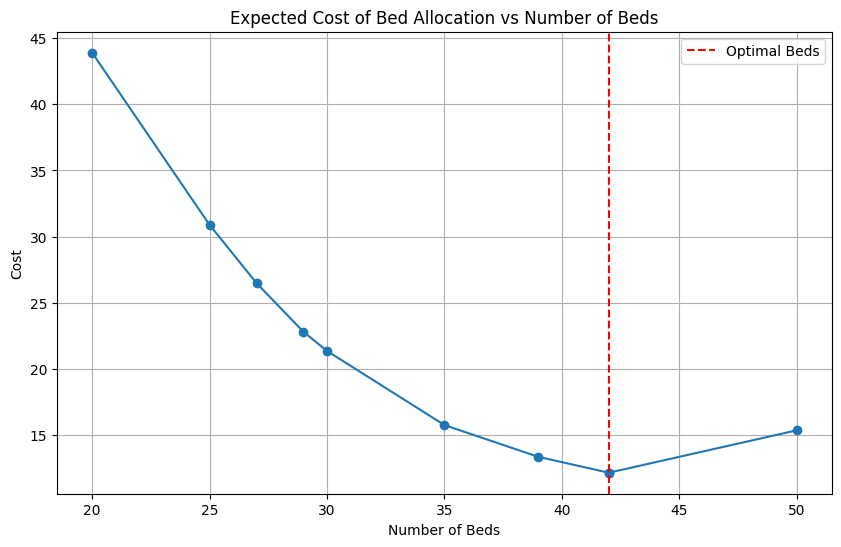

In [40]:
## Plotting
plt.figure(figsize= (10, 6))
plt.plot(allocation, allocation_cost, marker= 'o')
plt.axvline(opt_beds, color= 'red', linestyle= '--', label= 'Optimal Beds')

plt.xlabel('Number of Beds')
plt.ylabel('Cost')
plt.title('Expected Cost of Bed Allocation vs Number of Beds')
plt.legend()
plt.grid()